Imports for Provernance Part of Task D

In [1]:
from prov.model import ProvDocument
from prov.dot import prov_to_dot
import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image

Setup provenance document and NetworkX graph

In [2]:
document = ProvDocument()
document.add_namespace("Leeds", "Leeds")
document.add_namespace("Civ", "Civilian")
document.add_namespace("Pol", "Police")
police = document.agent("Pol:Police")

G = nx.DiGraph()

Functions to create events in the provernanace netowrk and the assosciations between things

In [3]:
# Generate driver and their car and the association between the two.
def createDriver(name):
    driver = document.agent("Civ:person_" + name)
    car = document.entity("Civ:car_" + name)
    document.wasAttributedTo(car, driver)
    G.add_edge(car, driver)
    return (driver, car)

# Generate a car crash report, including the activity, and the associations between all the entities, activites, and agents. 
def createCarCrash(driverOne, driverTwo, street):
    car_crash_id = int(random.uniform(0,1 * 10)*1000)
    activity = document.activity(f"Civ:crash_car_{car_crash_id}")
    car_crash_report = document.entity(f"Pol:car_crash_report_{car_crash_id}" )
    document.used(activity, driverOne[1])
    G.add_edge(activity, driverOne[1])
    document.used(activity, driverTwo[1])
    G.add_edge(activity, driverTwo[1])
    document.used(activity, street)
    G.add_edge(activity, street)
    document.wasAssociatedWith(activity, driverOne[0])
    G.add_edge(activity, driverOne[0])
    document.wasAssociatedWith(activity, driverTwo[0])
    G.add_edge(activity, driverTwo[0])
    document.wasGeneratedBy(car_crash_report, activity)
    G.add_edge(car_crash_report, activity)
    document.wasAttributedTo(car_crash_report, police)
    G.add_edge(car_crash_report, police)
    return car_crash_report

In [4]:
# Create the streets
streets = []
streets.append(document.entity("Leeds:Trent Street"))
streets.append(document.entity("Leeds:Thames Street"))
streets.append(document.entity("Leeds:Taf Street"))
streets.append(document.entity("Leeds:Lune Street"))
random_streets = random.choices(streets, [1,1,25,1], k=30)


# Create The Cars
driver_car_pairs = []
for i in range(0,8):
    driver_car_pairs.append(createDriver(str(i)))

# Create The Car Crashes
for i in range(0,len(driver_car_pairs) - 1, 2):
    createCarCrash(driver_car_pairs[i], driver_car_pairs[i+1], random_streets[i])

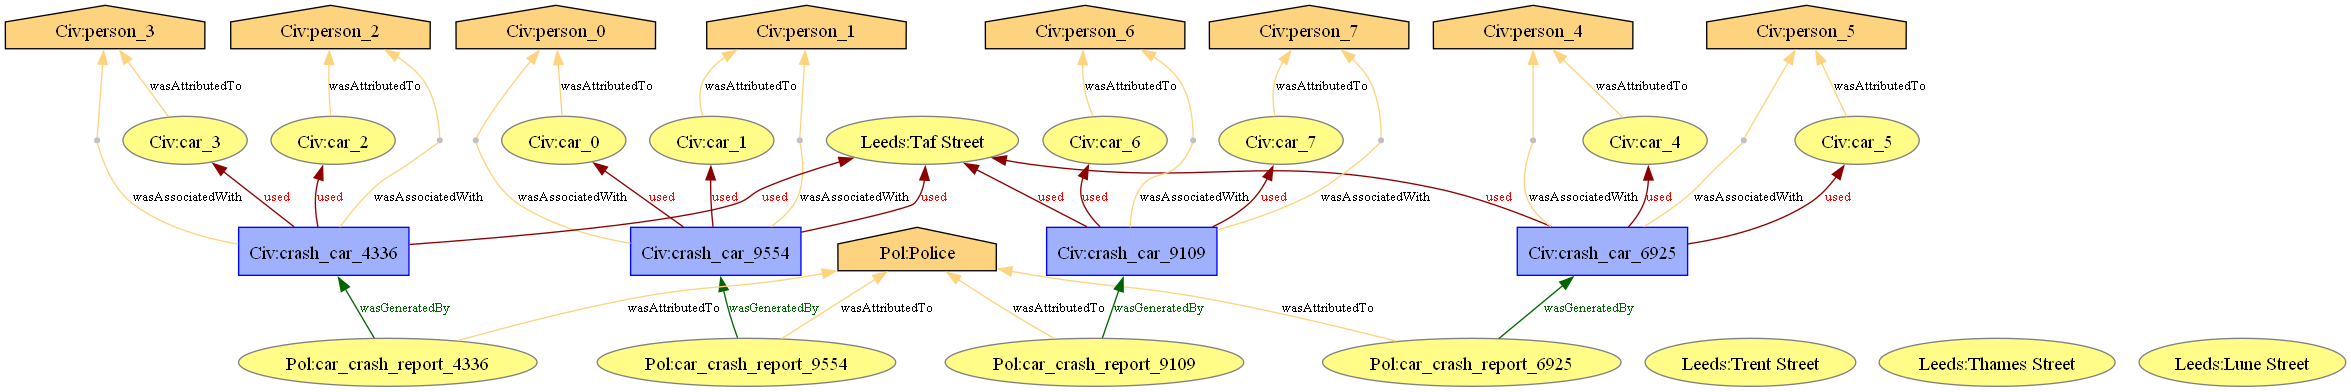

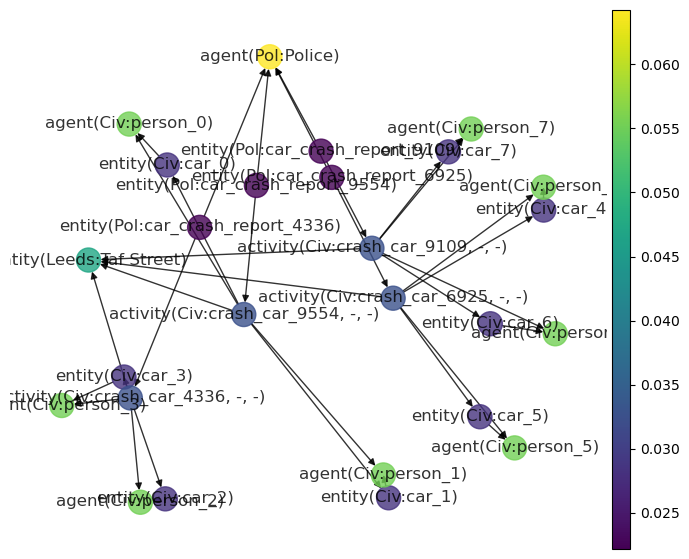

In [5]:
# Code from adapted from week 10 labs
# https://github.kcl.ac.uk/k21190656/7CUSMNDA-2024/blob/main/notebooks/week_10.ipynb
def plot_pagerank(graph, pagerank):
    fig, ax = plt.subplots(1, 1, figsize=(8, 7))

    node_color = list(pagerank.values())
    # nx.draw(graph, with_labels=False, alpha=0.8, arrows=True, node_color=node_color, cmap=plt.cm.viridis) 
    nx.draw(graph, with_labels=True, alpha=0.8, arrows=True, node_color=node_color, cmap=plt.cm.viridis) 

    # adding color bar for pagerank importances
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('viridis'), norm=colors.Normalize(vmin=min(node_color), vmax=max(node_color)))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(sm, cax=cax)

dot = prov_to_dot(document)
plot_pagerank(G, nx.pagerank(G, alpha= 0.95))
dot.write_png("leeds-prov.png")
Image(filename="leeds-prov.png")
plt.savefig("leeds-pagerank.png")
# plt.show()


Start of 

In [ ]:
from pykeen.datasets import CoDExMedium
from pykeen.pipeline import pipeline
from pykeen.hpo import hpo_pipeline
from pykeen.evaluation import RankBasedEvaluator
from pykeen.sampling import BasicNegativeSampler
from pykeen.models import CompGCN
from optuna.samplers import GridSampler


Import the CoDExMedium dataset

In [ ]:
dataset = CoDExMedium(create_inverse_triples=False)

In [ ]:
TransE_hpo_pipeline_result = hpo_pipeline(
    dataset = dataset,
    model='TransE',
    device='gpu',
    training_loop='sLCWA',
    model_kwargs_ranges=dict(embedding_dim=dict(type=int, low=16, high=256, step=16)),
    negative_sampler_kwargs_ranges=dict(num_negs_per_pos=dict(type=int, low=1, high=100), filtered=dict(type="bool")),
    n_trials= 2,
    optimizer_kwargs=dict(lr=1.0e-2),
    training_kwargs=dict(num_epochs=20, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=True),

    negative_sampler=BasicNegativeSampler,
    evaluator=RankBasedEvaluator
)

TransE_hpo_pipeline_result.save_to_directory("TransE.HPO")



TransE

In [ ]:
TransE_pipeline_result = pipeline(
    dataset=dataset,
    model='TransE',
    model_kwargs=dict(embedding_dim=50),
    optimizer_kwargs=dict(lr=1.0e-2),
    training_kwargs=dict(num_epochs=20, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=True),
    random_seed=1,
    device='gpu',
    training_loop='sLCWA',
    negative_sampler=BasicNegativeSampler,
    evaluator=RankBasedEvaluator
)

fig, ax = plt.subplots(figsize=(12, 4))
TransE_pipeline_result.plot_losses()
mrr = TransE_pipeline_result.get_metric('mrr')
hits_at_10 = TransE_pipeline_result.get_metric('hits@k')
print("The Mean Reciprocal Rank is: " + str(mrr))
print("The Hits at 10 is: " + str(hits_at_10))

In [ ]:
TransE2_pipeline_result = pipeline(
    dataset=dataset,
    model='TransE',
    model_kwargs=dict(embedding_dim=65),
    optimizer_kwargs=dict(lr=1.0e-2),
    training_kwargs=dict(num_epochs=3, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=True),
    random_seed=1,
    device='gpu',
    training_loop='sLCWA',
    negative_sampler=BasicNegativeSampler,
    evaluator=RankBasedEvaluator
)

fig, ax = plt.subplots(figsize=(12, 4))
TransE2_pipeline_result.plot_losses()
mrr = TransE2_pipeline_result.get_metric('mrr')
hits_at_10 = TransE2_pipeline_result.get_metric('hits@k')
print("The Mean Reciprocal Rank is: " + str(mrr))
print("The Hits at 10 is: " + str(hits_at_10))

RotatE

In [ ]:
RotatE_pipeline_result_ro = pipeline(
    dataset=dataset,
    model='RotatE',
    model_kwargs=dict(embedding_dim=50),
    optimizer_kwargs=dict(lr=1.0e-2),
    training_kwargs=dict(num_epochs=128, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=True),
    random_seed=1,
    device='gpu',
    training_loop='sLCWA',
    negative_sampler=BasicNegativeSampler,
    evaluator = RankBasedEvaluator
)

GCN

In [ ]:
pipeline_result_gcn = pipeline(
    dataset=dataset,
    model=CompGCN,
    model_kwargs=dict(embedding_dim=50),
    optimizer_kwargs=dict(lr=1.0e-2),
    training_kwargs=dict(num_epochs=128, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=True),
    random_seed=1,
    device='gpu',
    training_loop='sLCWA',
    negative_sampler=BasicNegativeSampler,
    evaluator = RankBasedEvaluator
)